# Steepest descent (analysis of step size)

Given the following cost function to optimize:
$$J = \frac{1}{2} ||\mathbf{d} - \mathbf{G} \mathbf{m}||_2^2 $$

Here we want to investigate the convergence speed of steepest descent (full gradient) and stochastic gradient descent.


- Gradient descent:
    
    $$\mathbf{m}_{k+1} = \mathbf{m}_{k} + \alpha \frac{dJ}{d\mathbf{m}_{k}} $$
    
    where $\mathbf{r} = \mathbf{G}^T(\mathbf{d} - \mathbf{G}\mathbf{m})$, $\frac{dJ}{d\mathbf{m}} = \mathbf{r}$, $\alpha = const$
    

- Steepest descent (faster due to analytical line search):
    
    $$\mathbf{m}_{k+1} = \mathbf{m}_{k} + \alpha_{k+1} \frac{dJ}{d\mathbf{m}_{k}} $$
    
    where $\alpha = \frac{\mathbf{r}^T \mathbf{r}}{\mathbf{r}^T  \mathbf{G}^H \mathbf{G} \mathbf{r}}$
    
- Stochastic gradient descent

    $$\mathbf{m}_{k+1} = \mathbf{m}_{k} + \alpha \frac{dJ_b}{d\mathbf{m}_{k}} $$

    where $\mathbf{r}_b = \mathbf{G}_b^T(\mathbf{d}_b - \mathbf{G}_b\mathbf{m})$, $\frac{dJ_b}{d\mathbf{m}} = \mathbf{r}_b$ with $\mathbf{G}_b$ and $\mathbf{d}_b$ are a row selection of $\mathbf{G}$ and $\mathbf{d}$ (with size of the batch), $\alpha = const$

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from pylops import *
from stochmdd.steepest import *
from stochmdd.stochmdd_numpy import SGD, SAG

plt.style.use('default')  # seaborn-whitegrid, ggplot, bmh

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 18

plt.rc('text', usetex=True)

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)     # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)   # fontsize of the figure title
plt.rc('font', weight='bold')  # fontsize of the figure title

np.random.seed(10)

Let's start by setting up the forward problem. 

We also compute the condition number of the operator $\mathbf{G}$ - note: the further the conditioning number from 1 the further the behaviour of the two solvers we will use in the following

In [2]:
n = 5000
m = np.array([1, 1])
G = np.random.uniform(0, 1, (n, 2))

print('G^T G', G.T @ G)
Gop = MatrixMult(G)
d = Gop @ m
L = np.linalg.eig(G.T @ G)[0].max()

print('d', d)
print('G eigenvalues', np.linalg.eig(G.T @ G)[0])
print('G condition number %f' % np.linalg.cond(G.T @ G))

G^T G [[1619.82227352 1223.3068303 ]
 [1223.3068303  1638.93707985]]
d [0.79207259 1.38245212 0.72330366 ... 0.42853137 0.32758271 1.27632369]
G eigenvalues [ 406.03551211 2852.72384126]
G condition number 7.025799


In [3]:
# cost function grid
nm1, nm2 = 51, 51
m_min, m_max = (m[0] - 1.2, m[1] - 1.2), (m[0] + 1.2, m[1] + 1.2)
m1, m2 = np.mgrid[m_min[0]:m_max[0]:1j*nm1, m_min[1]:m_max[1]:1j*nm2]
mgrid = np.vstack((m1.ravel(), m2.ravel()))

J = 0.5 * np.sum(mgrid * (G.T @ G @ mgrid), axis=0) - (mgrid.T @ G.T @ d[:, np.newaxis]).squeeze() + 0.5 *d.T @ d
J = J.reshape(nm1, nm2)

## Steepest descent

[1. 1.]


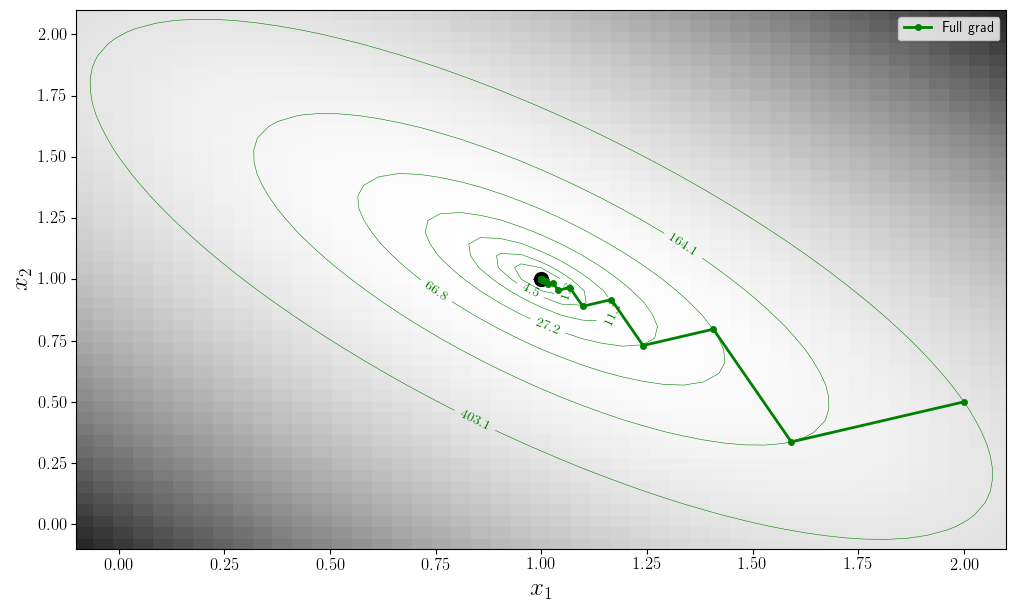

In [4]:
m0 = np.array([m[0]+1, m[1]-0.5])

# analytical stepsize
#msdana, rsdana, alphaana = steepest_descent(Gop.H @ Gop, Gop.H @ d, 
#                                            niter=50, m0=m0, a=None, tol=1e-3)
msdana, rsdana, alphaana = steepest_descent1(Gop, d, 
                                             niter=50, m0=m0, a=None, tol=0)
msdana = msdana.T
print(msdana[:, -1])

# cost function at solution
Jsdana = 0.5 * np.sum(msdana * (G.T @ G @ msdana), axis=0) - (msdana.T @ G.T @ d[:, np.newaxis]).squeeze() + 0.5 *d.T @ d
 
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
cs = ax.imshow(J.T, cmap='gray_r', origin='lower', extent=(m_min[0], m_max[0], m_min[1], m_max[1]))
cs = ax.contour(m1, m2, J, levels=np.sort(np.unique(Jsdana)), colors='g', linewidths=0.4)
ax.clabel(cs, inline=1, fontsize=10)
ax.plot(m[0], m[1], '.k', ms=20);
ax.plot(msdana[0], msdana[1], '.-g', lw=2, ms=8, label='Full grad')
ax.set_xlabel(r'$x_1$');
ax.set_ylabel(r'$x_2$');
ax.legend();
ax.axis('tight');
ax.set_xlim(-0.1, 2.1);
ax.set_ylim(-0.1, 2.1);

## Full gradient

In [5]:
def gradfun(Op, y, x):
        r = y - Op._matvec(x)
        loss = np.linalg.norm(r) ** 2
        g = -Op._rmatvec(r)
        return g, loss

In [6]:
xfgd = np.array([m[0]+1, m[1]-0.5])
xfgd_hist = [xfgd.copy(), ]
rfgd = [np.linalg.norm(Gop.H @(d - Gop @ xfgd)), ]
optimizer = SGD(xfgd, n/L)
Gop.grad = gradfun

for it in range(40):
    # Compute gradient
    grad, loss = Gop.grad(Gop, d.ravel(), xfgd)
    grad = grad /n
    
    # Update model
    optimizer.step(grad)
    
    xfgd_hist.append(xfgd.copy())
    rfgd.append(np.linalg.norm(Gop.H @(d - Gop @ xfgd)))
    
xfgd_hist = np.vstack(xfgd_hist).T
print(xfgd_hist[:, -1])


[1.00162207 0.99839055]


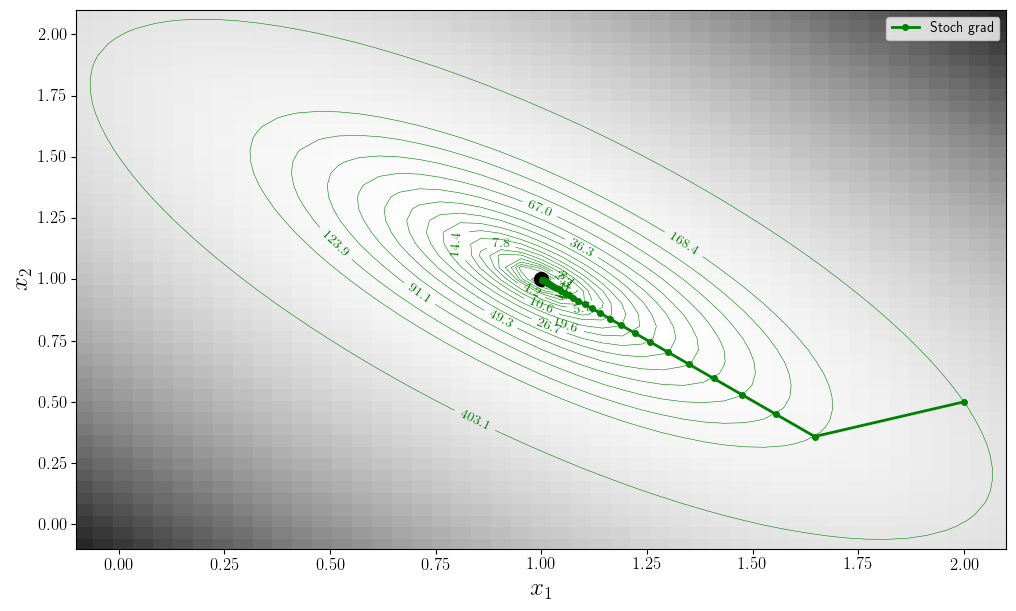

In [7]:
# cost function at solution
Jsdana = 0.5 * np.sum(xfgd_hist * (G.T @ G @ xfgd_hist), axis=0) - (xfgd_hist.T @ G.T @ d[:, np.newaxis]).squeeze() + 0.5 *d.T @ d
 
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
cs = ax.imshow(J.T, cmap='gray_r', origin='lower', extent=(m_min[0], m_max[0], m_min[1], m_max[1]))
cs = ax.contour(m1, m2, J, levels=np.sort(np.unique(Jsdana)), colors='g', linewidths=0.4)
ax.clabel(cs, inline=1, fontsize=10)
ax.plot(m[0], m[1], '.k', ms=20);
ax.plot(xfgd_hist[0], xfgd_hist[1], '.-g', lw=2, ms=8, label='Stoch grad')
ax.set_xlabel(r'$x_1$');
ax.set_ylabel(r'$x_2$');
ax.legend();
ax.axis('tight');
ax.set_xlim(-0.1, 2.1);
ax.set_ylim(-0.1, 2.1);

## Stochastic gradient

In [8]:
# sgd better
#batch_size = 1
#print(n/batch_size)

# sgd better
batch_size = 2
print(n/batch_size)

# sgd better
#batch_size = 5
#print(n/batch_size)

# sag better
#batch_size = 25
#print(n/batch_size)

2500.0


In [9]:
# Dividing now the gradient by batch_size (and using a consistent step-size)
xsgd = np.array([m[0]+1, m[1]-0.5])
xsgd_hist = [xsgd.copy(), ]
rsgd = [np.linalg.norm(Gop.H @(d - Gop @ xsgd)), ]
optimizer = SGD(xsgd, batch_size/L)# max allowed
optimizer = SGD(xsgd, 2*batch_size/L) # select LR larger than theory sometimes lead to better results (if it doesnt diverge)

#batches = np.random.permutation(np.arange(d.size)).reshape(d.size//batch_size, batch_size).astype(np.int)
for it in range(20):
    batches = np.random.permutation(np.arange(d.size)).reshape(n//batch_size, batch_size).astype(np.int)

    for batch in batches:
        #Make data and operator
        Gop1 = MatrixMult(G[batch])
        Gop1.grad = gradfun
        d1 = d[batch]
        
        # Compute gradient
        grad, loss = Gop1.grad(Gop1, d1, xsgd)
        grad = grad / batch_size
        
        # Update model
        optimizer.step(grad)

        xsgd_hist.append(xsgd.copy())
        rsgd.append(np.linalg.norm(Gop.H @(d - Gop @ xsgd)))

xsgd_hist = np.vstack(xsgd_hist).T
xsgd_hist_epochs = xsgd_hist[:, ::batches.shape[0]]
print(xsgd_hist[:, -1], xsgd_hist.shape)

[1.00254745 0.99749851] (2, 50001)


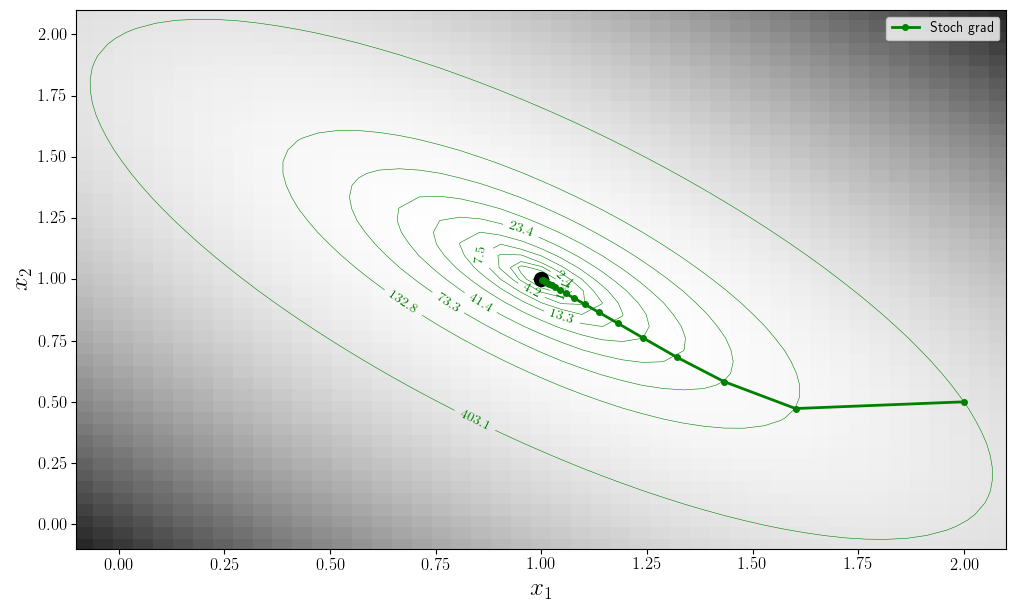

In [10]:
if n < xsgd_hist.shape[1] < 200:
    # cost function at solution
    Jsdana = 0.5 * np.sum(xsgd_hist * (G.T @ G @ xsgd_hist), axis=0) - (xsgd_hist.T @ G.T @ d[:, np.newaxis]).squeeze() + 0.5 *d.T @ d

    fig, ax = plt.subplots(1, 1, figsize=(12, 7))
    cs = ax.imshow(J.T, cmap='gray_r', origin='lower', extent=(m_min[0], m_max[0], m_min[1], m_max[1]))
    cs = ax.contour(m1, m2, J, levels=np.sort(np.unique(Jsdana)), colors='g', linewidths=0.4)
    ax.clabel(cs, inline=1, fontsize=10)
    ax.plot(m[0], m[1], '.k', ms=20);
    ax.plot(xsgd_hist[0], xsgd_hist[1], '.-g', lw=2, ms=8, label='Stoch grad')
    ax.set_xlabel(r'$x_1$');
    ax.set_ylabel(r'$x_2$');
    ax.legend();
    ax.axis('tight');
    ax.set_xlim(-0.1, 2.1);
    ax.set_ylim(-0.1, 2.1);

# cost function at solution
Jsdana = 0.5 * np.sum(xsgd_hist_epochs * (G.T @ G @ xsgd_hist_epochs), axis=0) - (xsgd_hist_epochs.T @ G.T @ d[:, np.newaxis]).squeeze() + 0.5 *d.T @ d
 
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
cs = ax.imshow(J.T, cmap='gray_r', origin='lower', extent=(m_min[0], m_max[0], m_min[1], m_max[1]))
cs = ax.contour(m1, m2, J, levels=np.sort(np.unique(Jsdana)), colors='g', linewidths=0.4)
ax.clabel(cs, inline=1, fontsize=10)
ax.plot(m[0], m[1], '.k', ms=20);
ax.plot(xsgd_hist_epochs[0], xsgd_hist_epochs[1], '.-g', lw=2, ms=8, label='Stoch grad')
ax.set_xlabel(r'$x_1$');
ax.set_ylabel(r'$x_2$');
ax.legend();
ax.axis('tight');
ax.set_xlim(-0.1, 2.1);
ax.set_ylim(-0.1, 2.1);

## SAG

In [11]:
# SAG
xsag = np.array([m[0]+1, m[1]-0.5])
xsag_hist = [xsag.copy(), ]
rsag = [np.linalg.norm(Gop.H @(d - Gop @ xsag)), ]
#optimizer = SAG(xsag, n/(16*L), n, int(n//batch_size), batch_size)
optimizer = SAG(xsag, 0.5*n/L, n, int(n//batch_size), batch_size)

np.random.seed(10)
batches = np.random.permutation(np.arange(n)).reshape(n//batch_size, batch_size).astype(np.int)
for it in range(int(n//batch_size)*20):
    ibatch = np.random.randint(0, int(n//batch_size))
    #Make data and operator
    Gop1 = MatrixMult(G[batches[ibatch]])
    Gop1.grad = gradfun
    d1 = d[batches[ibatch]]

    # Compute gradient
    grad, loss = Gop1.grad(Gop1, d1, xsag)
    grad = grad

    # Update model
    optimizer.step1(grad, ibatch=ibatch)

    xsag_hist.append(xsag.copy())
    rsag.append(np.linalg.norm(Gop.H @(d - Gop @ xsag)))

xsag_hist = np.vstack(xsag_hist).T
xsag_hist_epochs = xsag_hist[:, ::batches.shape[0]]
print(xsag_hist[:, -1], xsag_hist.shape)

[0.99967038 0.99920127] (2, 50001)


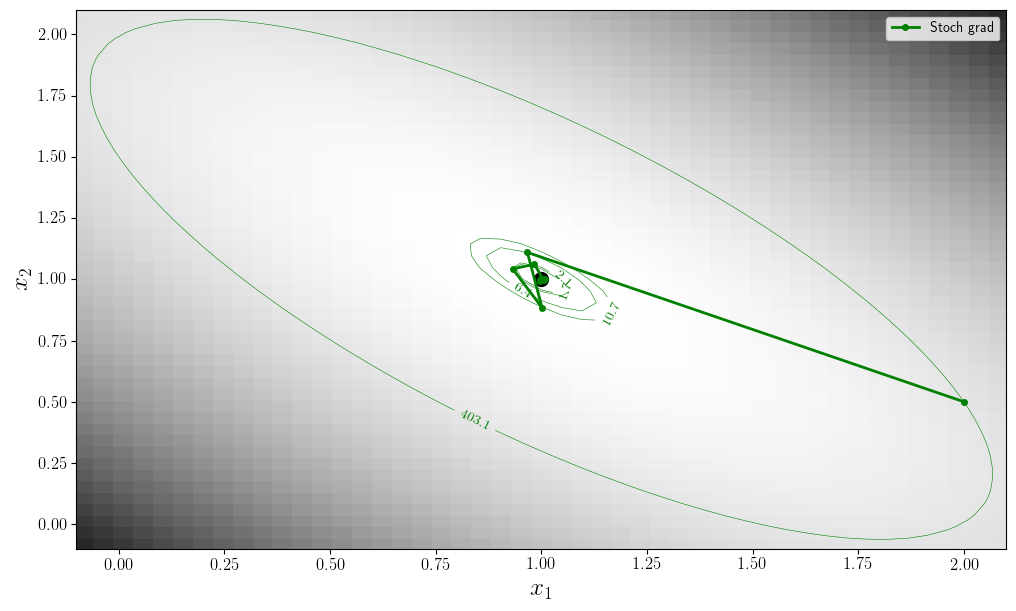

In [12]:
# cost function at solution
Jsdana = 0.5 * np.sum(xsag_hist_epochs * (G.T @ G @ xsag_hist_epochs), axis=0) - (xsag_hist_epochs.T @ G.T @ d[:, np.newaxis]).squeeze() + 0.5 *d.T @ d
 
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
cs = ax.imshow(J.T, cmap='gray_r', origin='lower', extent=(m_min[0], m_max[0], m_min[1], m_max[1]))
cs = ax.contour(m1, m2, J, levels=np.sort(np.unique(Jsdana)), colors='g', linewidths=0.4)
ax.clabel(cs, inline=1, fontsize=10)
ax.plot(m[0], m[1], '.k', ms=20);
ax.plot(xsag_hist_epochs[0], xsag_hist_epochs[1], '.-g', lw=2, ms=8, label='Stoch grad')
ax.set_xlabel(r'$x_1$');
ax.set_ylabel(r'$x_2$');
ax.legend();
ax.axis('tight');
ax.set_xlim(-0.1, 2.1);
ax.set_ylim(-0.1, 2.1);

In [13]:
# SAGA
xsaga = np.array([m[0]+1, m[1]-0.5])
xsaga_hist = [xsaga.copy(), ]
rsaga = [np.linalg.norm(Gop.H @(d - Gop @ xsaga)), ]
optimizer = SAG(xsaga, 0.01*n/(16*L), n, int(n//batch_size), batch_size, saga=True)

np.random.seed(10)
batches = np.random.permutation(np.arange(n)).reshape(n//batch_size, batch_size).astype(np.int)
for it in range(int(n//batch_size)*20):
    ibatch = np.random.randint(0, int(n//batch_size))
    #Make data and operator
    Gop1 = MatrixMult(G[batches[ibatch]])
    Gop1.grad = gradfun
    d1 = d[batches[ibatch]]

    # Compute gradient
    grad, loss = Gop1.grad(Gop1, d1, xsaga)
    grad = grad

    # Update model
    optimizer.step1(grad, ibatch=ibatch)

    xsaga_hist.append(xsaga.copy())
    rsaga.append(np.linalg.norm(Gop.H @(d - Gop @ xsaga)))

xsaga_hist = np.vstack(xsaga_hist).T
xsaga_hist_epochs = xsaga_hist[:, ::batches.shape[0]]
print(xsaga_hist[:, -1], xsaga_hist.shape)

[1.0003506  0.99965277] (2, 50001)


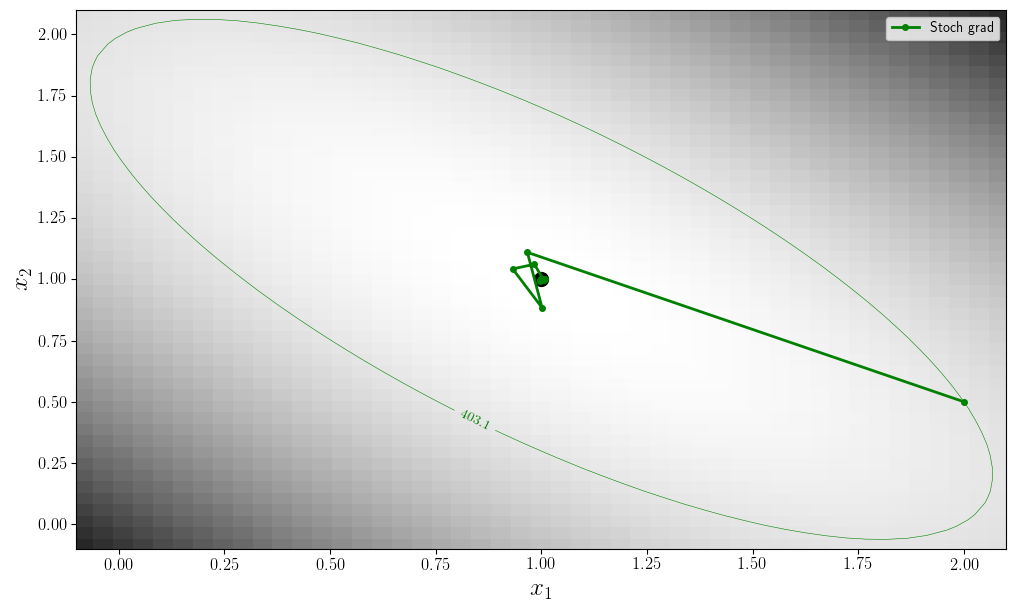

In [14]:
# cost function at solution
Jsdana = 0.5 * np.sum(xsaga_hist_epochs * (G.T @ G @ xsaga_hist_epochs), axis=0) - (xsaga_hist_epochs.T @ G.T @ d[:, np.newaxis]).squeeze() + 0.5 *d.T @ d
 
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
cs = ax.imshow(J.T, cmap='gray_r', origin='lower', extent=(m_min[0], m_max[0], m_min[1], m_max[1]))
cs = ax.contour(m1, m2, J, levels=np.sort(np.unique(Jsdana)), colors='g', linewidths=0.4)
ax.clabel(cs, inline=1, fontsize=10)
ax.plot(m[0], m[1], '.k', ms=20);
ax.plot(xsag_hist_epochs[0], xsag_hist_epochs[1], '.-g', lw=2, ms=8, label='Stoch grad')
ax.set_xlabel(r'$x_1$');
ax.set_ylabel(r'$x_2$');
ax.legend();
ax.axis('tight');
ax.set_xlim(-0.1, 2.1);
ax.set_ylim(-0.1, 2.1);

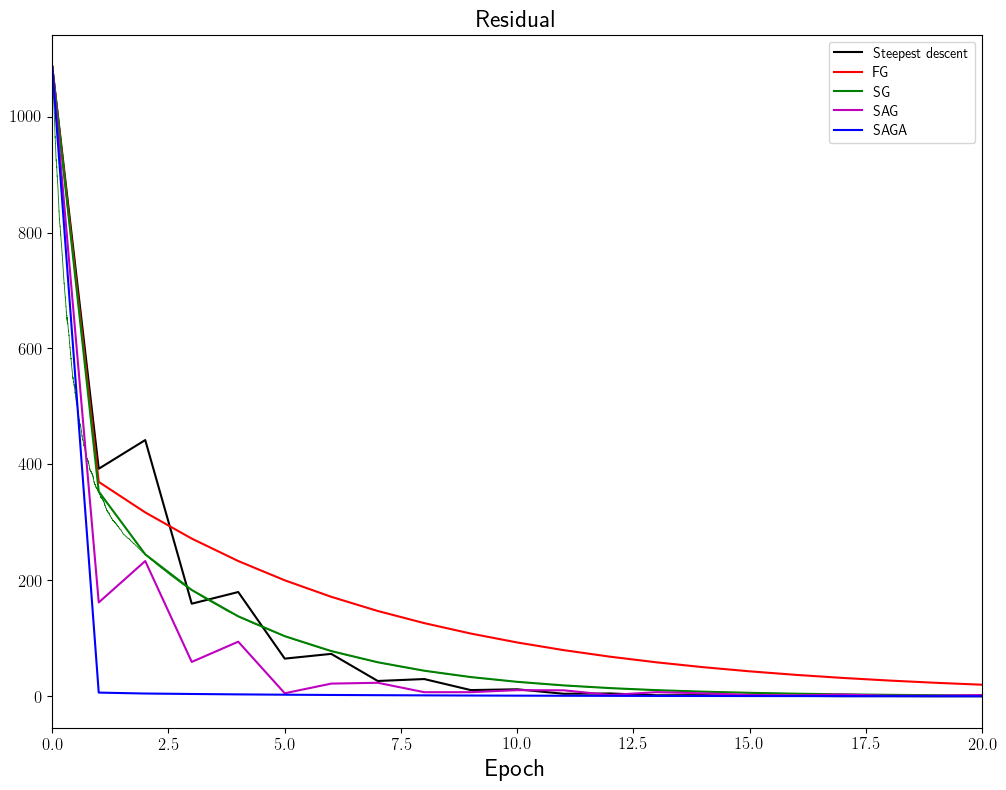

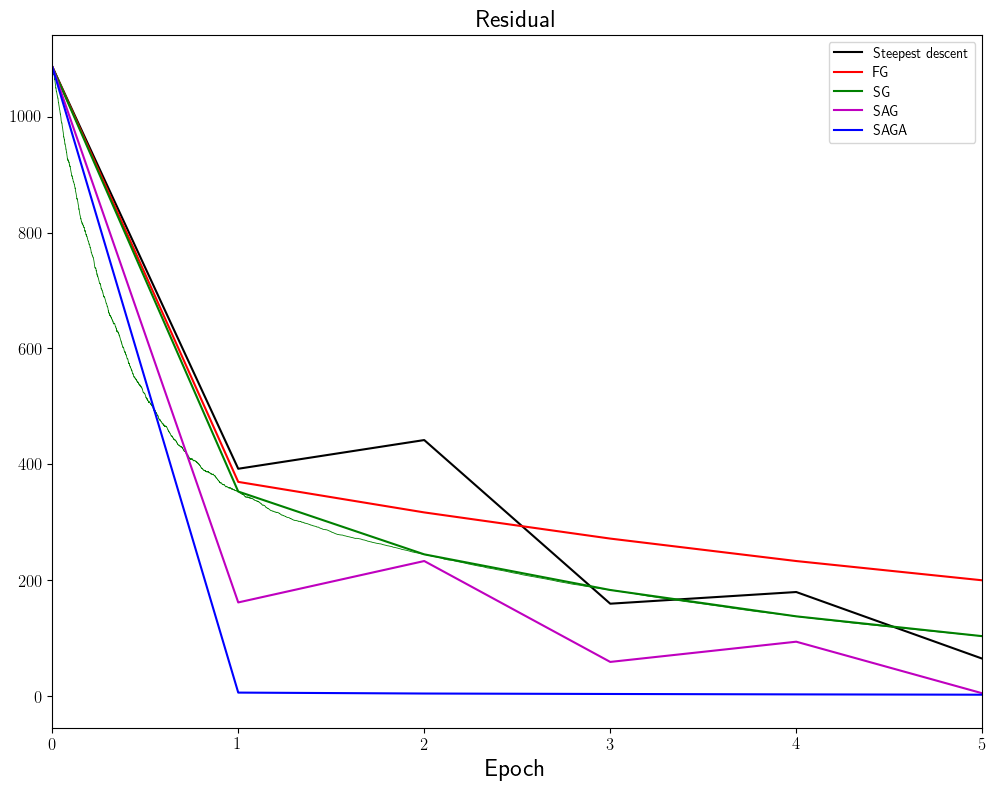

In [15]:
plt.figure(figsize=(12, 9))
plt.plot(rsdana, 'k', label='Steepest descent')
plt.plot(rfgd, 'r', label='FG')
plt.plot(np.linspace(0,20,20*batches.shape[0]+1), rsgd, 'g', lw=0.6)
plt.plot(rsgd[::batches.shape[0]], 'g', label='SG')
#plt.plot(np.linspace(0,20,20*batches.shape[0]+1), rsag, 'm', lw=0.6)
plt.plot(rsag[::batches.shape[0]], 'm', label='SAG')
#plt.plot(np.linspace(0,20,20*batches.shape[0]+1), rsaga, 'b', lw=0.6)
plt.plot(rsaga[::batches.shape[0]], 'b', label='SAGA')
plt.xlabel('Epoch')
plt.title('Residual')
plt.xlim(0,20)
plt.legend();

plt.figure(figsize=(12, 9))
plt.plot(rsdana, 'k', label='Steepest descent')
plt.plot(rfgd, 'r', label='FG')
plt.plot(np.linspace(0,20,20*batches.shape[0]+1), rsgd, 'g', lw=0.6)
plt.plot(rsgd[::batches.shape[0]], 'g', label='SG')
#plt.plot(np.linspace(0,20,20*batches.shape[0]+1), rsag, 'm', lw=0.6)
plt.plot(rsag[::batches.shape[0]], 'm', label='SAG')
#plt.plot(np.linspace(0,20,20*batches.shape[0]+1), rsaga, 'b', lw=0.6)
plt.plot(rsaga[::batches.shape[0]], 'b', label='SAGA')
plt.xlabel('Epoch')
plt.title('Residual')
plt.xlim(0,5)
plt.legend();